# Multi Layer Perceptron - Learning Techniques

This notebook will demonstrate the various aspects of neural networks that can be fine tuned in order to create a model more capable of generalising to the phenomena the network aims to emulate. I will discuss optimizers, loss functions and activation functions that are available in the Keras python library.

### Sections:

- [Optimisation Techniques](#Optimisation-Techniques)
    - [Momentum](#Momentum)
    - [Adagrad](#AdaGrad)
    - [Adadelta](#Adadelta)
    - [RMSprop](#RMSprop)
    - [Adam](#Adam)
- [Cost Functions](#Cost-Functions)
    - [Quadratic Limitations](#Limitations-of-the-quadratic-cost-function)
    - [Cross Entropy](#Cross-Entropy)
- [Activation Functions](#Activation-Functions)
    - [Sigmoid](#Sigmoid-Function)
    - [Hyperbolic Tangent](#Hyperbolic-Tangent---tanh)
    - [Rectified Linear Unit](#Rectified-Linear-Unit---ReLu)
    - [Softplus](#Softplus)
    - [Softmax](#Softmax)
- [Regularisation](#Regularisation-Techniques)
    - [Weight Decay](#Weight-Decay---L2-Regularisation)
    - [Dropout / Additional Data](#Dropout-and-Additional-Data)

I have replicated some examples taken from Michael Neilsons excellent [Neural Networks and Deep Learning book](http://neuralnetworksanddeeplearning.com/)

I aim to expand this notebook through time and explain various optimization techniques, activation functions and intialisations as I learn them.

## Optimisation Techniques

### Gradient Descent  Basics

Gradient descent is used across machine learning models in order to optimize a cost function. In gradient descent we try and move our error function towards a global minimum. Error surfaces are typically highly complex and may consist of many local minima. Gradient descent moves the error in the downward direction, if the error function reaches a local minima it may become stuck as any movement would require a temporary increase in energy. This is highly undesirable as we have not optimised our model. There are a couple of techniques used to overcome this problem.

### Gradient Descent Parameters:
### Learning Rate

The learning rate ($\eta$) controls the size of the weight change at each weight change step, $ \small 0 < \eta < 1 $. The gradient descent algorithm computes the partial derivative of the energy function with respect to the weights. The value of this equation is added to the original weights to complete the update. Choosing the right learning rate value is a compromise between time and optimal learning. If $\eta$ is small then only small weight changes are applied and the algorithm takes longer to converge. Altenratively if $\eta$ is large then large updates are applied and the algorithm may overshoot global minimum.

### Momentum

A momentum paramter (m) can be added to the gradient descent algorithm. This parameter helps the network escape from local minima. Momentum adds a proportion of the previous weight update to the current weight update. This has two benefits; 1) it accelerates learning towards a global minimum and 2) it helps the model overcome local minima. Number 1) can be explained by the fact that if the previous step was a large step in the negative direction of the gradient then a proportion of this large step is added to the current update. Steps will become increasingly larger as long as the gradient remains pointing in the same direction. 2) means that we potentially avoid the problem outlined in the learning rate description. If the model reaches a local minimum the momentum term may be sufficient to climb over the oncoming positive gradient and into a deeper minimum.

Weight update with momentum, t = timestep:

$ \nabla w_t = -\eta . \nabla E_{w_t} . m \nabla W_{t-1} $


## Alternative Optimizers

There are numerous optimization techniques available in the Keras library, here I discuss a few of them.

### Stochastic Gradient Descent
SGD is much more commonly used than simple gradient descent. SGD simply means picking training examples at random and applying the gradient descent algorithm to optimize the energy function. SGD can extend to mini batch learning, weight updates occur after a batch of training examples have been run through the network rather than after each training example.

### AdaGrad

Adaptive Gradient Algorithm: [Original Paper](http://jmlr.org/papers/volume12/duchi11a/duchi11a.pdf) and [Condensed notes](http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf)

The motivation behind the paper was to improve on the problem of a fixed learning rate that is applied to all weight updates. AdaGrad chooses a new learning rate for each update and is chosen based on the data. The algorithm chooses a learning rate that performs larger updates for infrequent parameters and smaller updates for frequent parameters. AdaGrad has been shown to increase convergence performance over SGD where data is sparse and thus sparse parameters are more informative.

In contrast to SGD we now need a learning rate parameter for every weight at every point in time. We therefore need to modify the learning rate at each update. Our update step thus becomes:

$  w_{t+1,i} = w_{t,i} - \eta . g_{t_i} $

where $g_t$ is the gradient at timestep t for weight i.

The modified learning rate is achieved by dividing the learning rate by the square root of a matrix computed from all previous gradients. The matrix is dxd and formed from the outer product of the previous gradient matrix multiplied by the new gradient vector. The diagonal of the matrix is therefore the sum of squares of the gradients wrt the weight and timestep. A smoothing term is added to the matrix to avoid division of 0.

$   w_{t+1, i} = w_{t-1, i}  - \dfrac{\eta}{\sqrt{G_{t,ii} + \epsilon}} \, g_{t,i} $

where w = weight at time t and weight i, $\eta$ = learning rate, G = outer product of previously calculated gradients for weight i and $\epsilon$ = smoothing term.

This can then be performed in one step for all weights. After dividing the learning rate by the gradient matrix, the matrix is multiplied, element-wise by the new gradient vector and subtracted from the previous weight vector. Notice we still start with a beginning general learning rate and it is this value that is modified depending on previous gradient values.

$  w_{t+1} = w_{t} - \dfrac{\eta}{\sqrt{G_{t} + \epsilon}} \odot g_{t} $

An additional benefit to applying Adagrad is the removal of the requirement to manually tune a learning rate

The gradient matrices must however be limited, 24 time steps are recommended. It would become far too expensive to store gradients otherwise. One flaw is that the denominator will eventually become so large that the learning rate will shrink to become redundant and thus prevent the algorithm from acquiring additional knowledge. This is caused by the fact each new term will be positive causing a large positive denominator.

### Adadelta

[Original Paper](http://www.matthewzeiler.com/pubs/googleTR2012/googleTR2012.pdf)

An extension of the Adagrad technique described above, this optimization technique aims to solve the diminishing returns when the sum of squared gradients becomes too large. Adadelta achieves this purpose by restricting the number of accumulated gradients to some fixed size window. The sum of gradients is recursively updated to become a decaying average of all previous squared gradients. The term now becomes a local estimator using recent gradients. At time t the running average is $E[g^2]_t$. We then get the equation:

$ E[g^2]_t = \rho E[g^2]_{t-1} + (1-\rho)\,g^2_t $

where $\rho$ is a decay constant, a fraction similar to the momentum term. and g is the gradient.

The matrix calculated in Adagrad is now replaced with this estimator term.

$ w_{t+1} = w_t - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t} $

The decaying average can now simply be converted to its abbreivated from of Root Mean Squared (RMS):

$ w_{t+1} = w_t - \dfrac{\eta}{RMS[g]_t} $

The units in this equation do not match, much like SGD and Adagrad. The authors wish to correct this and so proposed a hessian approximation. The specifics can be read in the paper but the final equation comes out as below:

$ w_{t+1} = w_t - \dfrac{RMS[\Delta w]_{t-1}}{RMS[g]_t} . g_t $

Handily the default learning rate $\eta$ has now also dissapeared.


### RMSprop

RMSprop is essentially the shortened version of Adadelta where instead of performing the hessian approximation to achieve matching units we accept the mismatch and keep the default learning rate.

$ w_{t+1} = w_t - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t}\; =\; w_t - \dfrac{\eta}{RMS[g]_t} $

This method was proposed by Hinton who suggests a $\rho$ of 0.9 and $\eta$ of 0.001

### Adam

Adaptive estimates of lower orders moments - [Original Paper](https://arxiv.org/pdf/1412.6980v8.pdf)

Again, this method focuses on adapting the learning rate per parameter. Adam introduces an extra term to the Adadelta equation by storing an exponentially decaying average of past gradients, similar to momentum.

As the name suggests, the algorithm requires the calculation of 1st and 2nd order moments, mean (m) and variance (v), of the gradients.

$ m_t = \beta_1 m_{t-1} + (1 - \beta_1)g_t \\ 
v_t = \beta_2 v_{t-1} + (1 - \beta_2) g^2_t $

$ g^2_t $ indicates the elementwise multiplication of $ g_t \odot g_t $

When initialising the moment vectors, they are set to 0 which can cause a bias towards 0. This is counteracted through the calculation of bias-corrected moment estimates.

$ \hat{m}_t = \dfrac{m_t}{1 - \beta^t_1} \\
\hat{v}_t = \dfrac{v_t}{1 - \beta^t_2} $

The two terms can then be substitued into the final update rule:

$ w_{t+1} = w_t - \dfrac{\eta . \hat{m}_t}{\sqrt{\hat{v}_t + \epsilon}} $

The authors state that good default settings for the tested machine learning problems are $\small \eta = 0.001, \beta_1 = 0.9,  \beta_2 = 0.999$  and $ \small \epsilon = 10e^{−8}$.


The code below builds a basic MLP Backprop model with the goal of classifying hand written digits. The model is built using Keras and the data is the classic MNIST dataset. Keeping all aspects of the model constant except the optimizer, we can see how the cost function performs per epoch for this particular problem.

I have previously prepared my own pickled files of the MNIST training data but it is widely available on the internet, [Here](http://yann.lecun.com/exdb/mnist/), [here](http://pjreddie.com/projects/mnist-in-csv/) and from Keras datasets [Example Code](https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py).

[[back to top](#Multi-Layer-Perceptron---Learning-Techniques)]

In [ ]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import callbacks

path = '/Users/Nick/Documents/Enrion/Datasets/'

X_train = pickle.load( open(os.path.join(path,"mnist_X_train.pkl"), "rb" ) )
X_test = pickle.load( open(os.path.join(path,"mnist_X_test.pkl"), "rb" ) )
y_train = pickle.load( open(os.path.join(path,"mnist_y_train.pkl"), "rb" ) )
y_test = pickle.load( open(os.path.join(path,"mnist_y_test.pkl"), "rb" ) )

def create_model():
    np.random.seed(10)

    model = Sequential()

    model.add(Dense(input_dim = X_train.shape[1],
                   output_dim = 50,
                    init = 'uniform',
                   activation = 'tanh'))
    model.add(Dense(input_dim = 50,
                   output_dim = 50,
                    init = 'uniform',
                   activation = 'tanh'))
    model.add(Dense(input_dim = 50,
                   output_dim = y_train.shape[1],
                    init = 'uniform',
                   activation = 'softmax'))
    return model

# Train each model with batch_size = 300, nb_epochs = 50
# Create SGD optimizer with momentum value 0.9
momentum = SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
nb_epoch = 50
batchsize = 300

def train_and_record_loss(model, X, y, optimizer, nb_epoch, batchsize):
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])
    measures = model.fit(X, y, nb_epoch = nb_epoch, batch_size=batchsize, verbose=0)
    losses = np.asarray(measures.history['loss'])
    final_acc = measures.history['acc'][-1]
    print("Completed: {}".format(optimizer))
    return losses, final_acc

sgd_losses, sgd_final_acc = train_and_record_loss(create_model(), X_train, y_train, 'sgd', nb_epoch, batchsize)
sgd_with_momentum_losses, sgd_with_momentum_final_acc = train_and_record_loss(create_model(), X_train, y_train, momentum, nb_epoch, batchsize)
adagrad_losses, adagrad_final_acc = train_and_record_loss(create_model(), X_train, y_train, 'adagrad', nb_epoch, batchsize)
adadelta_losses, adadelta_final_acc = train_and_record_loss(create_model(), X_train, y_train, 'adadelta', nb_epoch, batchsize)
rmsprop_losses, rmsprop_final_acc = train_and_record_loss(create_model(), X_train, y_train, 'rmsprop', nb_epoch, batchsize)
adam_losses, adam_final_acc = train_and_record_loss(create_model(), X_train, y_train, 'adam', nb_epoch, batchsize)

In [100]:
def print_accuracies():
    print("Final validation accuracies for each optimizer:\n")
    print('SGD: {:.2f}%'.format(sgd_final_acc*100))
    print('SGD with momentum: {:.2f}%'.format(sgd_with_momentum_final_acc*100))
    print('Adagrad: {:.2f}%'.format(adagrad_final_acc*100))
    print('Adadelta: {:.2f}%'.format(adadelta_final_acc*100))
    print('RMSprop: {:.2f}%'.format(rmsprop_final_acc*100))
    print('Adam: {:.2f}%'.format(adam_final_acc*100))

Final validation accuracies for each optimizer:

SGD: 94.54%
SGD with momentum: 88.63%
Adagrad: 95.66%
Adadelta: 96.94%
RMSprop: 96.09%
Adam: 94.25%


<function matplotlib.pyplot.show>

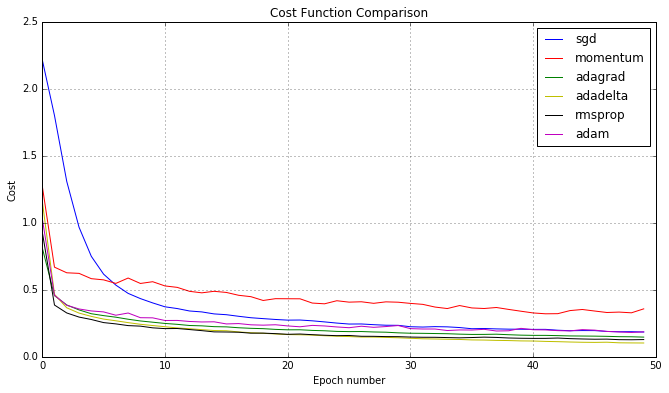

In [105]:
# List loss arrays, labels and colours
optimizers = [sgd_losses, sgd_with_momentum_losses, adagrad_losses, adadelta_losses, rmsprop_losses, adam_losses]
labels = ['sgd', 'momentum', 'adagrad', 'adadelta', 'rmsprop', 'adam']
colors = ['b','r','g','y','k','m']

print_accuracies()

fig = plt.figure(figsize=(11,6))

for i,losses in enumerate(optimizers):
    plt.plot(np.arange(0,50), losses, color=colors[i], label = labels[i])
plt.xlabel('Epoch number')
plt.ylabel('Cost')
plt.title('Cost Function Comparison')
plt.legend()
plt.grid()
plt.show

The above plot shows that for this particular classification problem the optimization techniques that performed the best are the new sgd adaptations that use modified learning rates; adadelta and rmsprop.

We can also see that SGD takes the longest to reduce its cost, needing 7 epochs to come below 0.5.

Final accuracy values are taken from the final validation test in epoch 50, accuracy on test set would be expected to be lower.

[[back to top](#Multi-Layer-Perceptron---Learning-Techniques)]

## Cost Functions

### Limitations of the quadratic cost function

Quatratic cost function: 

$ C(w,b) = \dfrac{1}{2n}  \sum( \|o - t\|^2 ) $

where o = output and t = target

The cell below shows a case with 1 neuron, 1 weight and 1 bias. The input value is 1 and the neuron is trained to emit a target output of 0.

The quadratic cost function can be shown to cause the neuron to be a very slow learner depending on the initial random value of the weight and bias.

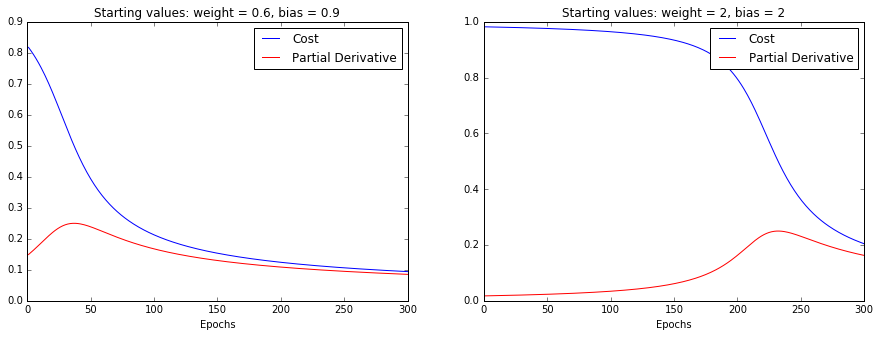

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

        
def run_neuron(x,y,w,b,lr, cost_function):
    cost = []
    partial_deriv = []
    for k in range(1,301):
        z = w*x + b
        output = 1 / (1+np.exp(-z))
        deriv = output*(1-output)
        err = (output - y)
        partial_deriv.append(deriv)
        cost.append(err)
        cross_ent_output = (y*np.log(output)) + ((1-y)*np.log(1-output))
        if cost_function == 'quadratic':
            w = w -(err * deriv * lr * x)
            b = b -(err * deriv * lr)
        elif cost_function == 'cross-entropy':
            w = w -(-cross_ent_output * lr * x)
            b = b -(-cross_ent_output * lr)
    return partial_deriv, cost, output

partial_deriv, cost, output = run_neuron(1,0,0.6,0.9,0.15,'quadratic')
partial_deriv_2, cost_2, output_2 = run_neuron(1,0,2,2,0.15,'quadratic')

def create_subplot(pd, cost, pd2, cost2):
    x_axis = np.arange(1,len(cost)+1)

    fig, ax = plt.subplots(1,2, figsize=(15,5))

    blue_line1 = ax[0].plot(x_axis,cost,color='b',label='Cost')
    red_line1 = ax[0].plot(x_axis,pd,color='r',label='Partial Derivative')
    h, l = ax[0].get_legend_handles_labels()
    ax[0].legend(h,l)
    ax[0].set_title('Starting values: weight = 0.6, bias = 0.9')
    ax[0].set_xlabel('Epochs')

    blue_line2 = ax[1].plot(x_axis,cost2,color='b',label='Cost')
    red_line2 = ax[1].plot(x_axis,pd2,color='r',label='Partial Derivative')
    h, l = ax[1].get_legend_handles_labels()
    ax[1].legend(h,l)
    ax[1].set_title('Starting values: weight = 2, bias = 2')
    ax[1].set_xlabel('Epochs')
    
    return fig

fig = create_subplot(partial_deriv, cost, partial_deriv_2, cost_2)
plt.show()

The left graph has initial random weight of 0.6 and bias 0.9.
The right graph has initial random weight of 2 and bias 2.

The graphs show that the initialisation of these random values significantly effects the speed at which the neuron learns. The neuron moves towards the target value quickly in the Left graph, as depicted by the blue line. After 300 epochs it has an output value of 0.09. The right graph however learns at a much slower rate and doesn't begin to accelerate learning until after 200 epochs, eventually yielding an output of 0.2 after 300 epochs.

This slow learning rate is caused by the small partial derivative, the red line shows the difference in calculated partial derivatives of the two models. When the partial derivative begins to increase in the right graph the cost decreases in response. This essentially means that when the model is badly wrong, it struggles to correct itself more than when it is only a little wrong. This problem has been shown to extend to much larger neural networks.

### Cross Entropy 

The cross entropy function:

$ C = -\dfrac{1}{n} \sum\limits_{xi} \,[t_i\ln o_i + (1-t_i)\ln (1-o_i] $

where $ t_i $ = target, $ o_i $ = output, n is total number of training examples and ln = natural log

Details on how the above equation meets the criteria of a cost function can be read from various sources including the link given in this notebook. The main concern here is to demonstrate its effectiveness in comparison to the quadratic cost function. The main benefit given by cross entropy is that it avoids the problem of slow learning.

Instead of using the partial derivative, now the model uses the output value for changing the weights. This means we are no longer dependant on small partial derivatives and instead learn directly from the distance between output and target value.

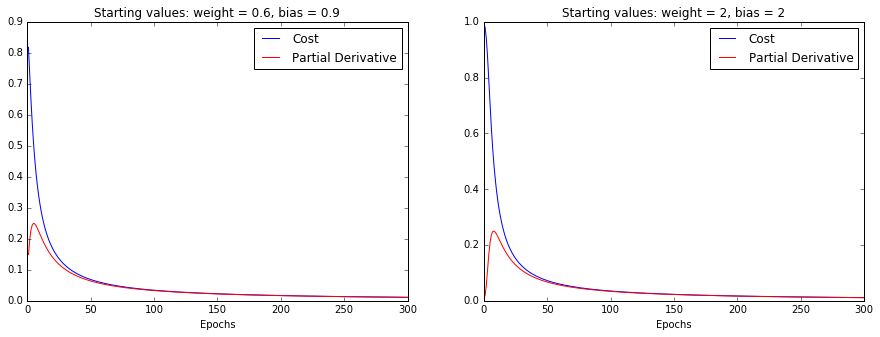

In [20]:
partial_deriv_CE, cost_CE, output_CE = run_neuron(1,0,0.6,0.9,0.15,'cross-entropy')
partial_deriv_CE2, cost_CE2, output_CE2 = run_neuron(1,0,2,2,0.15,'cross-entropy')

fig2 = create_subplot(partial_deriv_CE, cost_CE, partial_deriv_CE2, cost_CE2)
plt.show()

Immedietely we can see the benefit of cross entropy. The cost decreases rapidly when the output is far away from the target value. This is what we desire when training a model. The function is also easily extensible to situations where y can take numerous outputs. This makes the function suitable for multi-class classification.

[[back to top](#Multi-Layer-Perceptron---Learning-Techniques)]

## Activation Functions

### Sigmoid Function

Several activation functions can be applied to the layers of a neural network. Traditionally the sigmoid activation function was most commonly applied, its origins came from probabilistic thinking, P(neuron fires). The sigmoid function squashes its output to between 0 and 1 and can be viewed on a graph as an s shaped curve. The function suffers from a few problems:
1) Highly negative inputs result in near zero outputs meaning the network learns very slowly
2) Slow learning can result in being trapped in local minima
3) In deep neural networks a vanishing gradient problem can occur due to near 1 or 0 outputs.

$ f(z) = \dfrac{1}{1 + \exp^{-z}} $

Derivative:

$ f'(z) = f(z)(1-f(z)) $

### Hyperbolic Tangent - tanh

An extension of the sigmoid function, the tanh function spreads the range of its outputs to [-1,1]. This larger output spectrum improves the convergence of the backprop algorithm. While this reduces some of the problems posed by the sigmoid function it still has some trouble with some deep neural network architectures.

$ f(z) = \dfrac{\exp^{z} - \exp^{-z}}{\exp^{z} + \exp^{-z}} $

Derivative:

$ f'(z) = 1 - f(z)^2 $

### Rectified Linear Unit - ReLu

The rectified linear units is a recently applied activation function and is commonly used in deep neural networks where it effectively negates the problem of vanishing gradients. It has been applied with much success in the fields of computer vision and speech recognition. Unlike the sigmoid and tanh the function has no upper boundary and saturates at 0 for inputs equal to or below 0.

$ f(z)=\max(0,z) $ 

### Softplus

The softplus activation unit is a smooth approximation of the ReLu activation function. It provides a smooth curve towards negative outputs rather than a hard 0. Additional variants include a Noisy ReLu and leaky ReLu which both attempt to avoid the problem of not being able to differentiate 0 which original ReLu suffers from.

Softplus:

$ f(z) = ln(1+e^z) $

Derivative:

$ f'(z) = \dfrac{1}{1 + \exp^{-z}} $

The derivative of the softplus is recognisable as it is the sigmoid function.

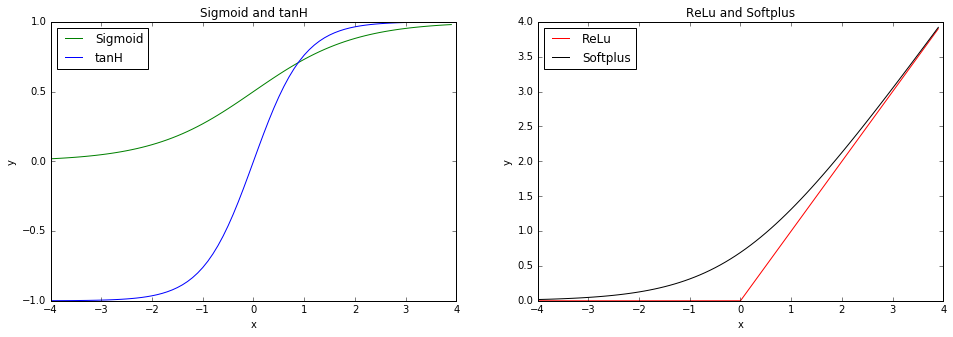

In [56]:
import numpy as np

def logistic(z):
    return 1.0 / (1.0 + np.exp(-z))

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def relu(z):
    maxVal = []
    for val in z:
        maxVal.append(max(0,val))
    return maxVal

def softP(z):
    return np.log(1+np.exp(z))

x = np.arange(-4,4,0.1)
sig = logistic(x)
tan = tanh(x)
reLu = relu(x)
softplus = softP(x)

figure, ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(x,sig,c='g',label='Sigmoid')
ax[0].plot(x,tan,c='b',label='tanH')
ax[0].set_title('Sigmoid and tanH')
ax[0].set_ylabel('y')
ax[0].set_xlabel('x')
h, l = ax[0].get_legend_handles_labels()
ax[0].legend(h,l,loc='best')

ax[1].plot(x,reLu,c='r',label='ReLu')
ax[1].plot(x,softplus,c='k',label='Softplus')
ax[1].set_title('ReLu and Softplus')
ax[1].set_ylabel('y')
ax[1].set_xlabel('x')
h, l = ax[1].get_legend_handles_labels()
ax[1].legend(h,l,loc='best')

plt.show()

### Softmax

The Softmax function is only used in output layers of a neural network and is a useful equation for extending binary classification to multi-class classification. The function computes a probability distribution for each example over all possible classes. The softmax function is a generalization of the logistic regression function used for binary classification, this can be proved through derivation which would result in the recognisable logistic function where $ \small P(y=1|x) = \frac{1}{1 + \exp^{-z}} $ and $ \small P(y=0|x) = 1 - p $

Sofmtax Function:

$ \large y_i = \frac{\exp^{z_i}}{\sum_j \exp^{z_j}} $

Our output probability distribution can be used to analyse the certainty of prediction. The exponential outputs are summed, all outputs now relate to one another. As one value increases, its probability of being the predicted class becomes stronger, this is realised at the expense of the other classes whose probability values drop.

The below example shows an output layer with 5 neurons, the outputs have been stored in the variables a-e.
The values in the interactive sliders represent the output values from a Neural Network. A softmax activation function converts these values into a probability distribution. By dragging the sliders, it is easy to visualise how neuron output values relative to one another effect the final class probability.

In [2]:
from ipywidgets import interactive, interact
from IPython.display import display
import numpy as np

def f(a=1,b=0,c=1.5,d=2,e=-1):
    a_e, b_e, c_e, d_e, e_e = np.exp(a), np.exp(b), np.exp(c), np.exp(d), np.exp(e)
    total = a_e + b_e + c_e + d_e + e_e
    print("Prob Class A: {:.2f}%".format(a_e / total * 100))
    print("Prob Class B: {:.2f}%".format(b_e / total * 100))
    print("Prob Class C: {:.2f}%".format(c_e / total * 100))
    print("Prob Class D: {:.2f}%".format(d_e / total * 100))
    print("Prob Class E: {:.2f}%".format(e_e / total * 100))

w = interactive(f, a=(-2,3,0.1), b=(-2,3,0.1),c=(-2,3,0.1),d=(-2,3,0.1),e=(-2,3,0.1))

display(w)

Prob Class A: 13.46%
Prob Class B: 9.98%
Prob Class C: 22.20%
Prob Class D: 4.95%
Prob Class E: 49.41%


[[back to top](#Multi-Layer-Perceptron---Learning-Techniques)]

## Regularisation Techniques

### Weight Decay - L2 Regularisation

The weight decay is a term that is added to the cost function.

$ Weight\, decay = \dfrac{\lambda}{2n}  \sum  w^2 $

λ is the term that can be tuned, w is the weights of the network and n is the number of training examples. The multiplier 2 will cancel when the partial derivative wrt w is calculated.

The weight decay term encourages the network to learn small weights by penalising larger weights. Large weights are only accepted when they significantly improve the cost function. Alternatively this regularisation term can be viewed as a method of trading of finding small weights against improvement in the cost function. By including the weight decay term the cost function is extended as follows:

$ C = C_0 + \dfrac{\lambda}{2n} \, \sum  w^2 $

$C_0$ is the original cost function e.g. cross entropy

The position of lambda dictates its use. When large values of lambda are chosen, it has the effect of manipulating the network to learn small weights at potential cost to optimisation. By choosing small values of lambda the user prefers optimisation instead of small weights.

**Why are small weights desired?**

There is an assumption in science, dating back to occams razor that the simplest explanation should be the correct one. When models are created with small weights they are much more resilient to the introduction of new inputs. This means that additional randomness or noise in the data won't change how the network models the data too strongly. In contrast if the network allows large weights, it may strongly change its behaviour in response to new inputs. The network will thus learn to model the noise in the training data. By adding the weight decay term and regularising a network, it does in effect produce a simpler model based on patterns seen in the training data and by proxy it becomes more resistant to noise and random error.


### Dropout and Additional Data

Additional regularisation techniques are a) dropout, discussed in a separate notebook complete with implementation in keras and b) increasing the number of training examples. More data often leads to more generalisable models. Several techniques exist to generate additional synthetic training examples. In the case of image recongition the original images can be rotated or translated to provide new training examples. For other areas of research one can apply SMOTE to the training data.

[[back to top](#Multi-Layer-Perceptron---Learning-Techniques)]